In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
from fastai.text import *

In [3]:
path_train = '/kaggle/input/nlp-getting-started/train.csv'
path_test = '/kaggle/input/nlp-getting-started/test.csv'

In [4]:
train_df = pd.read_csv(path_train)
test_df = pd.read_csv(path_test)

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [7]:
train_lm = pd.concat([train_df[['text']], test_df[['text']]])

In [8]:
train_lm.shape

(10876, 1)

In [9]:
train_lm.head()

,text
0,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...


In [10]:
data_lm = (TextList.from_df(train_lm).split_by_rand_pct(0.10).label_for_lm().databunch(bs=128))
data_lm.save('tmp_lm')

In [11]:
data_lm.show_batch()

idx,text
0,"# xxmaj alaska as smoke from # wildfires xxunk into a school xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk , xxmaj colorado xxmaj springs areas xxbos i 'm on top of the"
1,kenya coming forward to comment on the accident issue and xxunk xxunk # xxunk xxbos xxunk xxunk ps live and the game ... xxunk xxbos 320 [ xxup ir ] xxup icemoon [ xxup aftershock ] | http : / / t.co / xxunk | @djicemoon | # xxmaj dubstep # trapmusic # dnb # xxup edm # xxmaj dance # icesû _ http : / / t.co / xxunk
2,xxunk xxbos xxunk xxunk xxunk are you ok do you need medical assistance i can call an ambulance if you need me to xxbos xxup xxunk : xxup ny xxunk petition for $ 17 per hour xxunk xxunk http : / / t.co / xxunk # ems # xxunk # ambulance xxbos http : / / t.co / xxunk xxmaj twelve feared killed in xxmaj pakistani air ambulance helicopter crash
3,wild xxmaj horse ... https : / / t.co / xxunk via @change xxbos xxup u.s xxmaj national xxmaj park xxmaj services xxmaj tonto xxmaj national xxmaj forest : xxmaj stop the xxmaj annihilation of the xxmaj salt xxmaj river xxmaj wild xxmaj horse ... http : / / t.co / xxunk via @change xxbos i 'm gon na fight xxmaj taylor as soon as i get there . xxbos
4,for http : / / t.co / thoyhrhkfj xxmaj fan xxmaj army # xxmaj beyhive http : / / t.co / wvj39a3bgm xxbos xxunk xxmaj is my pick for http : / / t.co / thoyhrhkfj xxmaj fan xxmaj army # xxmaj beyhive http : / / t.co / wvj39a3bgm xxbos xxmaj one xxmaj direction xxmaj is my pick for http : / / t.co / q2eblokeve xxmaj fan xxmaj


In [12]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '/']

In [13]:
data_lm.train_ds[0]

(Text xxbos xxmaj our xxmaj xxunk are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj forgive us all,
 EmptyLabel )

In [14]:
data_lm.train_ds[0][0].data[:10]

array([  2,   5, 140,   5,   0,  41,  14,   5, 921,  19])

In [15]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


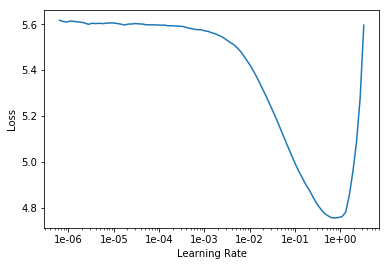

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(1,1e-02,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.422792,3.667933,0.391685,00:06


In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


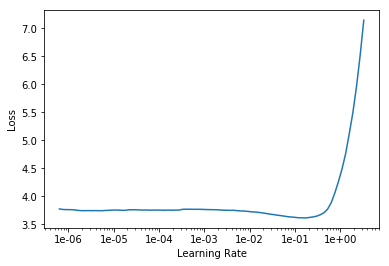

In [20]:
learn.recorder.plot()

In [21]:
learn.unfreeze()

In [22]:
learn.fit_one_cycle(4,1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,3.401310,3.173342,0.445815,00:06
1,3.041994,2.860351,0.487695,00:06
2,2.623611,2.830118,0.497656,00:06
3,2.246260,2.887260,0.496987,00:06


In [23]:
learn.save('learn1')

In [24]:
learn.load('learn1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (9789 items)
x: LMTextList
xxbos xxmaj our xxmaj xxunk are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj forgive us all,xxbos xxmaj all residents asked to ' shelter in place ' are being xxunk by officers . xxmaj no other evacuation or shelter in place orders are expected,xxbos xxunk people receive # wildfires evacuation orders in xxmaj california,xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school,xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (1087 items)
x: LMTextList
xxbos xxunk dude like he screams his soul out,xxbos xxmaj how to xxmaj remove xxmaj xxunk xxmaj hijacker ? xxmaj xxunk xxmaj xxunk xxmaj nature book xxmaj xxunk out xxmaj help xxup sea,xxbos xxmaj if you bored as shit do n't nobody fuck wit 

In [25]:
TEXT = "Just got sent this"
N_WORDS = 10
N_SENTENCES = 1

In [26]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Just got sent this to # Holland ? # ? ? MH370


In [27]:
learn.save_encoder('fine_tuned_enc')

In [28]:
data_cls = (TextList.from_df(train_df[['text', 'target']], vocab=data_lm.vocab).split_by_rand_pct(valid_pct = 0.1).label_from_df('target').databunch(bs=32))


In [29]:
learn = text_classifier_learner(data_cls, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(beta=1)])

In [30]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6852 items)
x: TextList
xxbos xxmaj our xxmaj xxunk are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj forgive us all,xxbos xxmaj forest fire near xxmaj la xxmaj xxunk xxmaj xxunk . xxmaj canada,xxbos xxmaj all residents asked to ' shelter in place ' are being xxunk by officers . xxmaj no other evacuation or shelter in place orders are expected,xxbos xxunk people receive # wildfires evacuation orders in xxmaj california,xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school
y: CategoryList
1,1,1,1,1
Path: .;

Valid: LabelList (761 items)
x: TextList
xxbos xxmaj earthquake : m xxunk - 96 km n of xxmaj xxunk xxmaj xxunk xxmaj xxunk : xxmaj time2015 - 08 - 05 xxunk xxup utc2015 - 08 - 05 xxunk xxunk atû _ http : / / t.co / xxunk,xxbos i liked a @youtube video from @dannyonpc http : / / t.co / xxunk xxmaj battlefield xxmaj hardline - 11 xxup new xxup weapons 

In [31]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


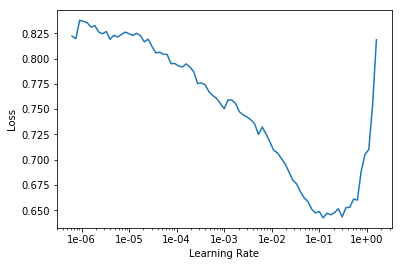

In [32]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.507914,0.472435,0.783180,0.737679,00:07


In [34]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.487728,0.459549,0.785808,0.730579,00:08


In [35]:
pred = []
for i in test_df['text']:
    pred.append(np.argmax(np.array(learn.predict(i)[2])))

In [36]:
test_df['target'] = pred
test_df.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [37]:
test_pd = test_df[['id','target']]

In [38]:
test_pd.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [39]:
test_pd.to_csv('submission.csv',index=False)